# Event Detection (& Association)
The first stage of the monitoring process is to detect anomalous events - short, transient signals of a few seconds to 1-2 minutes. The classic approach (since late 1970s?) has been to use a Short-Term Average (STA) to Long-Term Average (LTA) ratio-based Detector.

## Steps:
- Run an <b>STA/LTA Detector</b> on each channel of continuous waveform data (to each ObsPy Trace object wthin a Stream object).This yields a set of Trigger (or Detection) ON and OFF times.
- Run an <b>Associator</b> on the full set of Triggers. If multiple channels have Trigger ON status at the same time, record as an Event in a Catalog.

In ObsPy, both steps can be done using `coincidence_trigger` from the `obspy.signal.trigger` package.

## Examples:
1. Run an STA/LTA Detector on a single channel of data, on just 1 hour of data.
2. Run an STA/LTA Detector and Associator on multiple channels of data (a Stream object), on just 1 hour of data.
3. Run an STA/LTA Detection and Associator on multiple channels of data (a Stream object), for multiple days of data.

## Dataset
For this tutorial, we will use data from the Montserrat Volcano Observatory. On many occasions there was drumbeat seismicity in the days before a major dome collapse of the Soufriere Hills Volcano. We focus on the major dome collapse that occurred on July 12-13th, 2003.

The continuous waveform data will come from a "SeisComP Data Structure" (https://docs.obspy.org/packages/autogen/obspy.clients.filesystem.sds.html) or "SDS" archive. We will explore this first. We can create a client connection to as SDS archive using the Client class from the `obspy.clients.filesystem.sds` package.

In [1]:
# Import general packages
import os
import sys
from pathlib import Path
import obspy
import warnings
warnings.filterwarnings("ignore") # turn off warnings about Miniseed file encoding (and anything else!)

# Import local packages
sys.path.append('lib')
import vsmTools

# Define where SDS archive and EVENTS data are stored
DATA_DIR = os.path.join('data')
SDS_DIR = os.path.join(DATA_DIR, 'continuous','SDS')
EVENTS_DIR = os.path.join(DATA_DIR, 'events')
CATALOG_DIR = os.path.join(DATA_DIR,'catalogs')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

# Show a tree listing of SDS_DIR
print('Tree listing of SDS_DIR directory')
for line in vsmTools.tree(Path(os.path.join(SDS_DIR, '2003'))):
    print(line)



Tree listing of SDS_DIR directory
├── .DS_Store
└── MV
    ├── MBRY
    │   ├── BHE.D
    │   │   ├── MV.MBRY..BHE.D.2003.189
    │   │   ├── MV.MBRY..BHE.D.2003.187
    │   │   ├── MV.MBRY..BHE.D.2003.191
    │   │   ├── MV.MBRY..BHE.D.2003.192
    │   │   ├── MV.MBRY..BHE.D.2003.188
    │   │   └── MV.MBRY..BHE.D.2003.190
    │   ├── BHN.D
    │   │   ├── MV.MBRY..BHN.D.2003.191
    │   │   ├── MV.MBRY..BHN.D.2003.189
    │   │   ├── MV.MBRY..BHN.D.2003.188
    │   │   ├── MV.MBRY..BHN.D.2003.190
    │   │   ├── MV.MBRY..BHN.D.2003.192
    │   │   └── MV.MBRY..BHN.D.2003.187
    │   └── BHZ.D
    │       ├── MV.MBRY..BHZ.D.2003.197
    │       ├── MV.MBRY..BHZ.D.2003.196
    │       ├── MV.MBRY..BHZ.D.2003.195
    │       ├── MV.MBRY..BHZ.D.2003.192
    │       ├── MV.MBRY..BHZ.D.2003.193
    │       ├── MV.MBRY..BHZ.D.2003.187
    │       ├── MV.MBRY..BHZ.D.2003.190
    │       ├── MV.MBRY..BHZ.D.2003.189
    │       ├── MV.MBRY..BHZ.D.2003.188
    │       ├── MV.MBRY..BHZ.D.2003.19

Let's look at a helicorder plot of a few hours of data. This will help us choose appropriate STA/LTA parameters

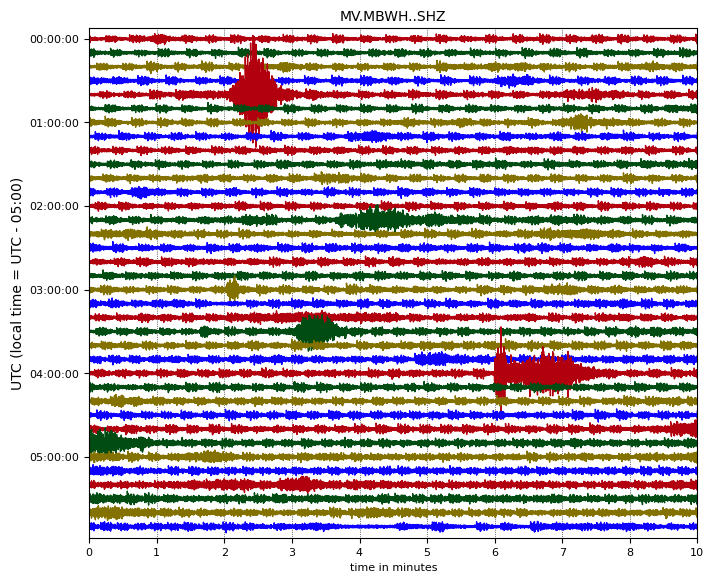

In [2]:
st = sdsclient.get_waveforms("MV", "MBWH", "", "SHZ", obspy.UTCDateTime(2003, 7, 11), obspy.UTCDateTime(2003, 7, 11, 6, 0, 0))
st.plot(type='dayplot', interval=10, vertical_scaling_range=3e3);

Looking above we can see there were up to 3 events per minute. 

Seismic and infrasound waves are essentially low-frequency sound waves in the ground and air respectively, so it makes sense to listen to them. ObsPy makes this easy to do:  

In [3]:
wav_audio_file = os.path.join(DATA_DIR, 'MV20030711.wav')
st[0].write(wav_audio_file, rescale=True, format='WAV', framerate=6000*2)
os.system(f'open {wav_audio_file}') # works on Ubuntu Linux 22.04

0

This is called 'drumbeat seismicity'! 

## Example 1: Detect anomalous signals in 1 hour of data

First we load one hour of data from the SDS archive (multiple channels):

2003-07-12T00:00:00.000000Z


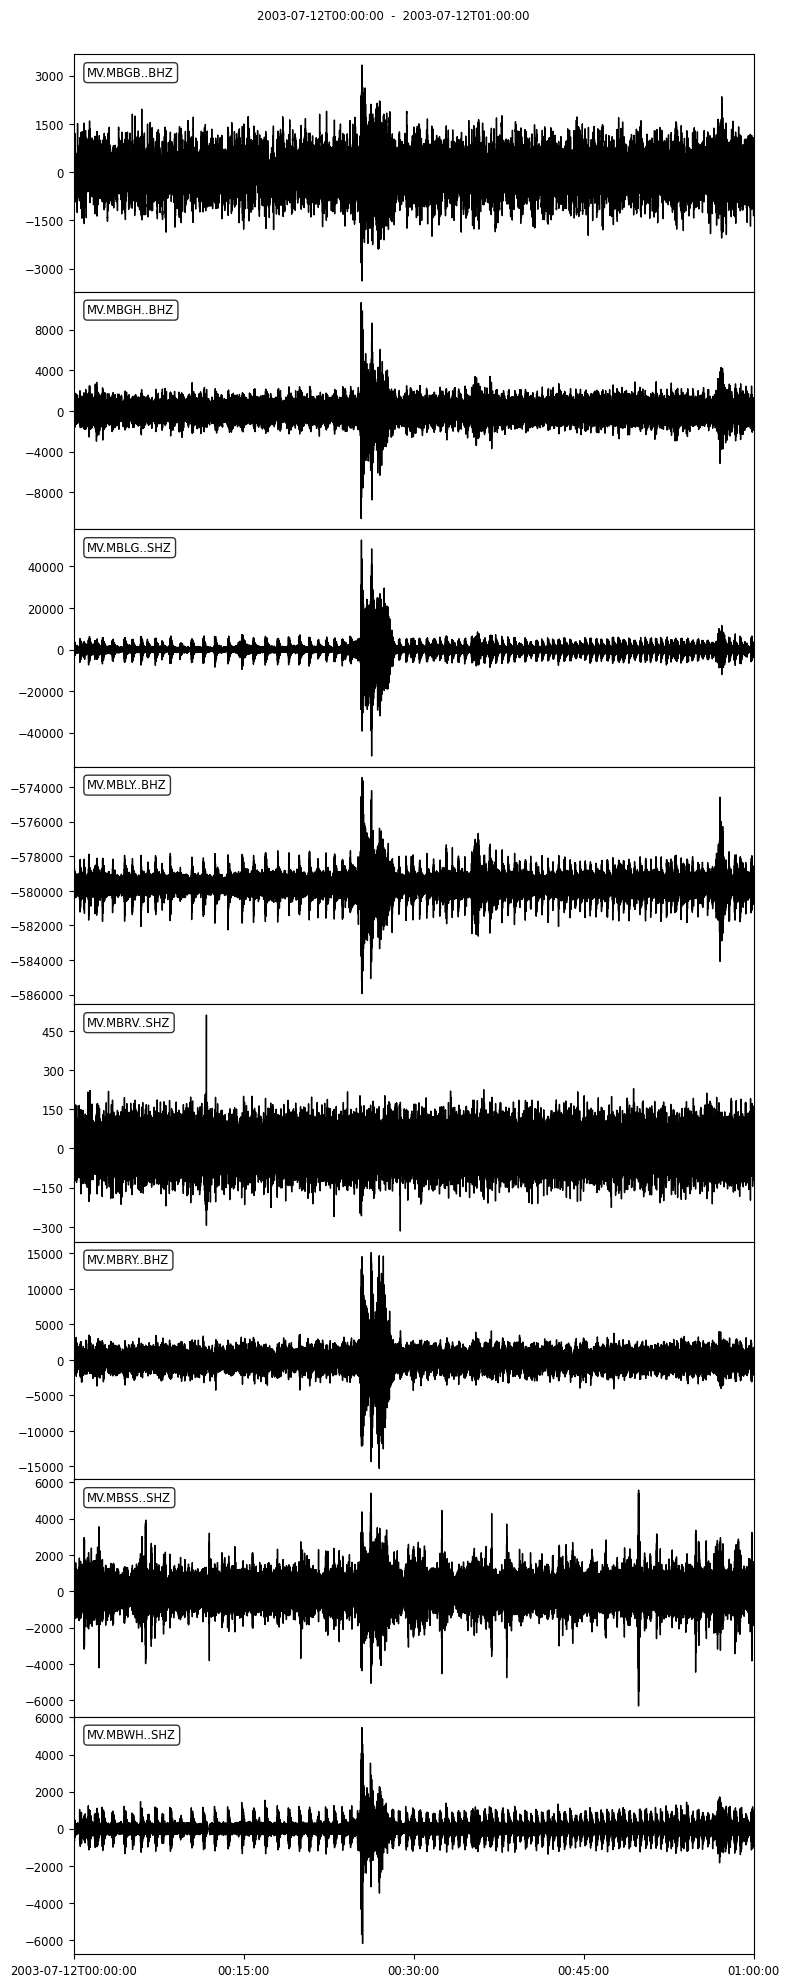

In [4]:
# Set start time as "YYYYJJJT" where JJJ = (Julian calendar) day of year
stime = obspy.UTCDateTime("2003193T")
print(stime)
seconds = 3600

# Get and plot data
st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+seconds)
st.plot(equal_scale=False);

Run STA/LTA Detector on the final Trace object (MV.MBWH..SHZ) in the Stream. We can use index = -1.

sampling_rate=75


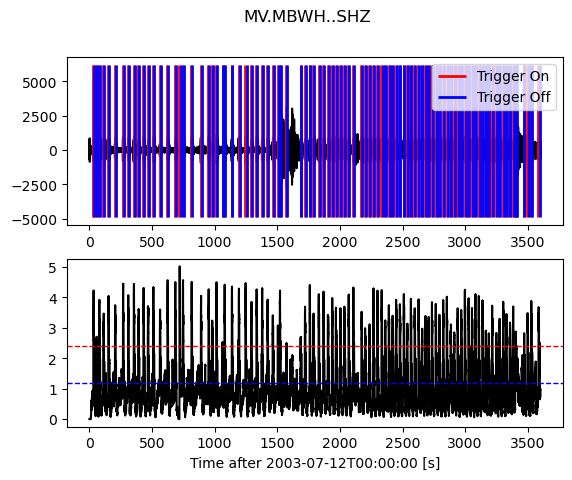

In [5]:
# Detection
import numpy as np
from obspy.signal.trigger import plot_trigger, classic_sta_lta

st2 = st.copy()

tr_index = -1

Fs = int(np.round(st[tr_index].stats.sampling_rate, 0))
print(f"sampling_rate={Fs}")

corners = 3
sta_secs = 2.3
lta_secs = 11.5
threshON = 2.4
threshOFF = 1.2
freqmin = 1.5
freqmax = 12.0    

st2.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
sta_samples = int(sta_secs * Fs)
lta_samples = int(lta_secs * Fs)

#cft = recursive_sta_lta(st2[tr_index].data, sta_samples, lta_samples )
#threshOFF = 1.2
cft = classic_sta_lta(st2[tr_index].data, sta_samples, lta_samples )

plot_trigger(st2[tr_index], cft, threshON, threshOFF)

The top plot shows Trigger ON (red lines) and Trigger OFF (blue lines) times. The bottom line shows the STA:LTA ratio, where "Trigger ON" (red) corresponds to 2.4, and "Trigger OFF" corresponds to 0.5).

## Example 2: Run STA/LTA on all (good) channels
Next we run `coincidence_trigger` on the whole Stream object, choosing the same 'Classic STA/LTA" method as before, and the same input parameters. Since we have 6 'good' channels (Trace objects), we will require at least 3 stations to trigger ON at the same time before a network trigger is declared.

In [6]:
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

threshStations = 3 # minimum number of channels that must reach trigger ON at the same time before a network trigger is declared.
max_secs = 120.0 # no trigger will remain on for longer than 2 minutes

staltamethod = 'classicstalta'
trig = coincidence_trigger(staltamethod, threshON , threshOFF, st2, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)

for i, this_trig in enumerate(trig):
    print('\n',f'Event {i}')
    pprint(this_trig)


 Event 0
{'cft_peak_wmean': 3.402753110560506,
 'cft_peaks': [4.220549534677409,
               3.8780554664950704,
               3.8952809861081916,
               2.61226613187896,
               2.57951466126799,
               3.2308518829354163],
 'cft_std_wmean': 0.5956587556927885,
 'cft_stds': [0.6423364381964485,
              0.7966319994597588,
              0.8609949006186585,
              0.46549959132815155,
              0.3160052485239939,
              0.49248435602971974],
 'coincidence_sum': 6.0,
 'duration': 9.586666703224182,
 'similarity': {},
 'stations': ['MBWH', 'MBLG', 'MBLY', 'MBRY', 'MBGB', 'MBGH'],
 'time': UTCDateTime(2003, 7, 12, 0, 0, 31, 400000),
 'trace_ids': ['MV.MBWH..SHZ',
               'MV.MBLG..SHZ',
               'MV.MBLY..BHZ',
               'MV.MBRY..BHZ',
               'MV.MBGB..BHZ',
               'MV.MBGH..BHZ']}

 Event 1
{'cft_peak_wmean': 3.119909983740284,
 'cft_peaks': [3.4113184973189083, 3.246499017374308, 2.7019124365276372],

93 network triggers were declared within that one hour time window. 

The trig variable is a list of dictionaries. Each dictionary describes a single network trigger, and contains fields including 'time' which has the UTCDateTime at which the network trigger began, 'coincidence_sum' stores the number of channels that simultaenously triggered, and 'trace_ids' tells us the specific channels that triggered. 

We will assume that each trigger a volcano-seismic event, i.e. a transient (short-lived) anomalous signal. ObsPy includes classes (object-oriented blueprints of new data types useful for Seismology) for storing each `Event` within a `Catalog`. The structure of an ObsPy `Event` object is based on the QuakeML format, and though this isn't great match for volcano-seismic events, we will create an `Event` object for each network trigger. However, rather than use an ObsPy `Catalog` object directly, we have created a new class `VolcanoSeismicCatalog` which inherits `Catalog` and expands on it. This should all be invisible to you - it happens in the `tools` package, imported above. All we have to do is call `tools.triggers2catalog` and it returns a `VolcanoSeismicCatalog` object.

It will also segment out a window of data for each Event beginning pretrig seconds before the trigger ON time and ending posttrig seconds after the trigger OFF time.

In [7]:
import pandas as pd
pretrig = 10 #lta_secs * 2
posttrig = 20 # lta_secs * 2   
catalogObj = vsmTools.triggers2catalog(trig, staltamethod, threshON, threshOFF, \
                                        sta_secs, lta_secs, max_secs, stream=st2, pretrig=pretrig, posttrig=posttrig )
    
print(catalogObj)

93 Event(s) in Catalog:
2003-07-12T00:00:31.400000Z | None, None | 0.54 None
2003-07-12T00:00:53.390000Z | None, None | 0.74 None
...
2003-07-12T00:58:46.160000Z | None, None | 0.58 None
2003-07-12T00:59:45.066667Z | None, None | 0.50 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


By expanding on the ObsPy `Catalog` class, we have added several new methods, some of which we will use. For example, we can make plots of event rate and energy release rate:

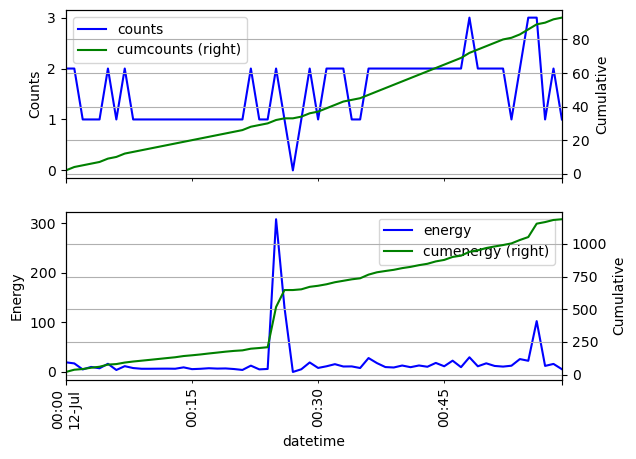

,magnitude,energy,latitude,longitude,depth,filename,duration,classification,counts,cumcounts,cumenergy
datetime,,,,,,,,,,,
2003-07-12 00:00:00,1.280199,19.444963,0,0,0,20030712T00003120030712T000053,15.276667,0,2,2,19.444963
2003-07-12 00:01:00,1.205601,17.228858,0,0,0,20030712T00011720030712T000151,17.626667,0,2,4,36.673822
2003-07-12 00:02:00,0.472302,5.110373,0,0,0,20030712T000230,8.666667,0,1,5,41.784195
2003-07-12 00:03:00,0.670549,10.135008,0,0,0,20030712T000324,8.760000,0,1,6,51.919203
2003-07-12 00:04:00,0.580766,7.432750,0,0,0,20030712T000427,11.333333,0,1,7,59.351953
2003-07-12 00:05:00,1.213089,16.458718,0,0,0,20030712T00050820030712T000553,22.120000,0,2,9,75.810671
2003-07-12 00:06:00,0.400602,3.989351,0,0,0,20030712T000630,8.933333,0,1,10,79.800022
2003-07-12 00:07:00,0.973281,11.674402,0,0,0,20030712T00071020030712T000742,21.760000,0,2,12,91.474424
2003-07-12 00:08:00,0.597728,7.881198,0,0,0,20030712T000828,11.173333,0,1,13,99.355622


In [8]:
catalogObj.plot_eventrate(binsize=pd.Timedelta(minutes=1))

So we have the basic ability to detect events. Unlike the examples in the presentation which are chosen for clarity and having an excellent signal to noise ratio, the events shown in the plots above are not really obvious at all. This is quite typical. Indeed, in this case we are trying to detect events amongst a background of heightened unrest - earthquake swarms that became drumbeat-like and merge into a continuous tremor. It is important to note that STA/LTA algorithms often break down when volcano-seismicity is at its highest!

Anyway, let us now try to run this on several days on data and see how many events we can detect.

## Example 3: Run coincidence trigger on multiple days, and concatenate catalogs for each day into one

(This takes about 1 minute to run on my office Linux PC)

In [9]:
# set parameters
threshStations = 3 # minimum number of stations that must trigger for a coincidence trigger to occur
max_secs = 120.0
staltamethod = 'classicstalta' 
corners = 3
sta_secs = 2.3
lta_secs = 11.5
threshON = 2.4
threshOFF = 1.2
freqmin = 1.5
freqmax = 12.0  
catalog_all = None

for jday in range(190, 197, 1): # Loop over days in SDS archive
    for hour in range(24):
        # set start time & show counting through days and hours
        stime = obspy.UTCDateTime(f"2003{jday}T") + hour * 3600
        if hour==0:
            print(stime.strftime('%Y/%m/%d %H'), end=' ')
        elif hour==23:
            print(stime.hour)
        else:
            print(stime.hour, end=' ')
    
        # Get and plot data
        st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+3600)
        if len(st)==0:
            continue
    
        # remove bad channels, including those with insufficient samples
        for tr in st:
            if tr.stats.npts < max_secs * tr.stats.sampling_rate:
                st.remove(tr)

        if len(st)==0:
            continue
    
        # bandpass filter
        st.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
    
        # run coincidence trigger for this day
        trig = coincidence_trigger(staltamethod, threshON , threshOFF, st, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)
        if len(trig)==0:
            continue

        # create catalog object
        catalogObj = vsmTools.triggers2catalog(trig, staltamethod, threshON, threshOFF, \
                                                      sta_secs, lta_secs, max_secs, stream=st, pretrig=pretrig, posttrig=posttrig )
    
        # save the event streams to miniseed, and then erase them to free up memory
        catalogObj.write_events(outdir=EVENTS_DIR)
        catalogObj.streams = []
    
        # concatenate catalogs
        if catalog_all:
            catalog_all.concat(catalogObj)
        else:
            catalog_all = catalogObj

2003/07/09 00 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
2003/07/10 00 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
2003/07/11 00 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
2003/07/12 00 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
2003/07/13 00 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
2003/07/14 00 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
2003/07/15 00 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23


If we print this ~10 day catalog, we see it has 4314 events. 

Since the events are not located, the latitude, longitude, and depth are set to None.

The magnitude (column that starts with 0.44) is not calibrated and is based on the log10(peak_amplitude) of each Trace. Since the Traces are raw (not instrument corrected), the peak amplitude is in Counts.

In [10]:
print(catalog_all)

4314 Event(s) in Catalog:
2003-07-09T00:00:15.973333Z | None, None | 0.44 None
2003-07-09T00:10:52.493333Z | None, None | 0.93 None
...
2003-07-15T23:22:25.520000Z | None, None | 0.70 None
2003-07-15T23:49:44.840000Z | None, None | 0.25 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


We can print a single event too:

In [11]:
print(catalog_all.events[0])

Event:	2003-07-09T00:00:15.973333Z | None, None | 0.44 None

	        resource_id: ResourceIdentifier(id="smi:local/9d4d377a-8263-4101-b994-9e135e7acf5f")
	      creation_info: CreationInfo(author='coincidence_trigger', creation_time=UTCDateTime(2024, 3, 1, 20, 33, 44, 195010))
	               ---------
	         amplitudes: 4 Elements
	            origins: 1 Elements
	         magnitudes: 1 Elements
	 station_magnitudes: 4 Elements


And view the amplitude information that came from the coincidence trigger: 

In [12]:
for a in catalog_all.events[0].amplitudes: # a is an ObsPy Amplitude object
    print(f"id={a['waveform_id'].id}, amp={a['generic_amplitude']:.1f}, snr={a['snr']:.2f}")

id=MV.MBGB..BHZ, amp=289.8, snr=100.90
id=MV.MBGH..BHZ, amp=930.9, snr=3.23
id=MV.MBLG..SHZ, amp=2930.9, snr=3.19
id=MV.MBLY..BHZ, amp=736.0, snr=2.43


We also have a very first-order magnitude, which is uncalibrated (we'll improve on this soon), but somewhat useful as a real-time relative size indicator. It is computed as the base-10 logarithm of the median amplitude of an event across the set of triggered stations:

In [13]:
for sm in catalog_all.events[0].station_magnitudes: # a is an ObsPy Amplitude object
    print(f"id={sm['waveform_id'].id}, mag={sm['mag']:.1f}")
for m in catalog_all.events[0].magnitudes: # a is an ObsPy Amplitude object
    print(f"magnitude={m['mag']:.1f}")

id=MV.MBGB..BHZ, mag=-0.0
id=MV.MBGH..BHZ, mag=0.5
id=MV.MBLG..SHZ, mag=1.0
id=MV.MBLY..BHZ, mag=0.4
magnitude=0.4


### Convert catalog object to a pandas DataFrame
While it is great to make use of the ObsPy Catalog class(which we inherited and expanded into a VolcanoSeismicCatalog class), so we can leverage its methods like exporting to QuakeML, it is also much easier to work with a pandas dataframe.

Anyone not familiar with pandas dataframes? They are like Excel spreadsheets (and can be imported from and exported to Excel spreadsheets or CSV files), but are far more powerful!

Anyway, we convert a VolcanoSeismicCatalog object to a dataframe like this:

In [14]:
catDF = catalog_all.to_dataframe()

And we can view it like any other pandas dataframe:

In [15]:
print(catDF)

                       datetime  magnitude      energy latitude longitude  \
0    2003-07-09 00:00:15.973333   0.441214    4.590089     None      None   
1    2003-07-09 00:10:52.493333   0.925142   24.418153     None      None   
2    2003-07-09 00:17:47.666667   1.533111  199.373275     None      None   
3    2003-07-09 00:38:13.420000   1.010757   32.819771     None      None   
4    2003-07-09 00:40:00.466667   0.883722   21.163250     None      None   
...                         ...        ...         ...      ...       ...   
4309 2003-07-15 22:52:48.280000   0.547465    6.625185     None      None   
4310 2003-07-15 23:06:58.180000   0.932011   25.004417     None      None   
4311 2003-07-15 23:19:36.093333   0.559924    6.916487     None      None   
4312 2003-07-15 23:22:25.520000   0.700489   11.239168     None      None   
4313 2003-07-15 23:49:44.840000   0.246315    2.341383     None      None   

     depth         filename    duration classification  
0     None  200307

As you can see, so far we have no latitude/longitude/depth coordinates, and no classifications. The energy column here is based on the magnitude - and we'll improve on this in later notebooks.

And pandas dataframes with a datetime index/column are easy to plot, for example:

<Axes: xlabel='Date', ylabel='Trigger duration (s)'>

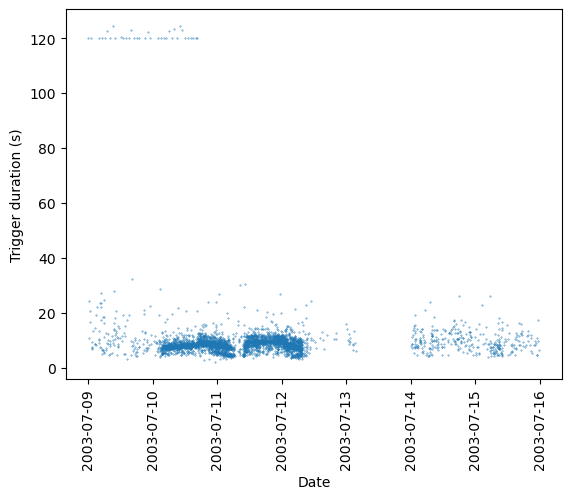

In [16]:
catDF.plot.scatter(x='datetime', y='duration', s=0.1, rot=90, xlabel='Date', ylabel='Trigger duration (s)')

Recall that 120s was our max trigger length. A few of the events early on are 120s long. But the bulk of the events are much shorter. Indeed, we can change the y-limits and see: 

(0.0, 20.0)

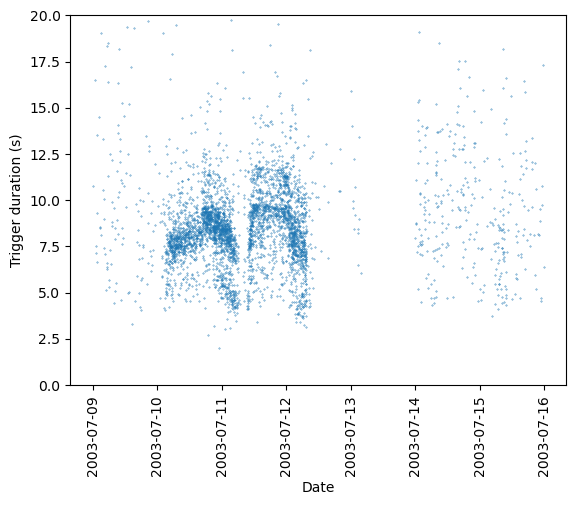

In [17]:
ax = catDF.plot.scatter(x='datetime', y='duration', s=0.1, rot=90, xlabel='Date', ylabel='Trigger duration (s)')
ax.set_ylim([0,20])

This means we did a good job of capturing short transient events, but missed longer signals. This is a common trade-off with STA/LTA methods.

(0.0, 3.0)

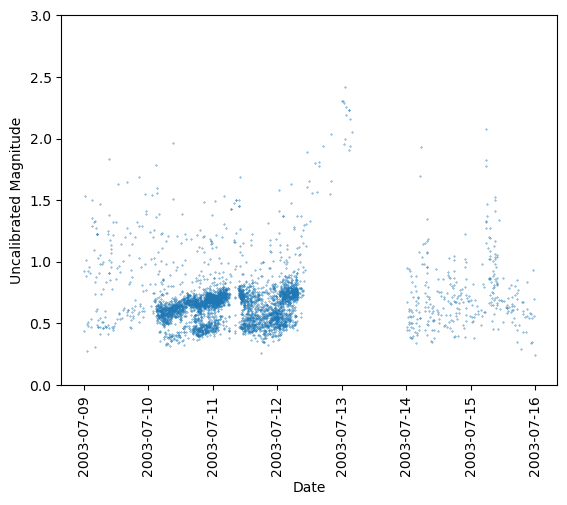

In [18]:
ax = catDF.plot.scatter(x='datetime', y='magnitude', s=0.1, rot=90, xlabel='Date', ylabel='Uncalibrated Magnitude')
ax.set_ylim([0, 3])

We can observe that the magnitude of the detected events increases significantly from about 2003/07/12 08:00 until about 2003/07/13 02:00. Let's see what is happening in the raw data: 

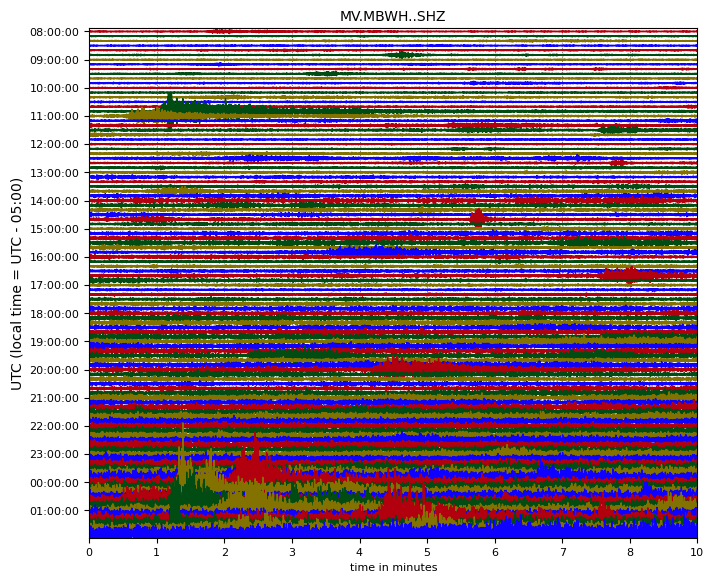

In [19]:
st2 = sdsclient.get_waveforms("MV", "MBWH", "", "SHZ", obspy.UTCDateTime(2003, 7, 12, 8, 0, 0), obspy.UTCDateTime(2003, 7, 13, 2, 0, 0))
st2.plot(type='dayplot', interval=10, vertical_scaling_range=8e3);

We observe that the background level of seismicity is increasing. This is a progressive dome collapse that began with intense rainfall leading to lahars and individual pyroclastic flows that eventually become near-continuous and larger until most of the dome is gone. such rainfall-triggered dome collapses were common in Montserrat, and this underlines the importance of real-time rain gauge data. However, this was very much a dome that was ready collapse, since drumbeat seismicity usually resulted in dome collapses after 2-3 days. What isn't clear from this plot is whether the drumbeats merged into tremor as the drumbeats become drowned out by tremor-like lahar signals and much larger pyroclastic flow signals.

Let's save the whole catalog so we can load it in later notebooks. This creates an QuakeML (extension ".xml") file of the whole catalog, plus a Pickle file (extension ".pkl") containing variables that QuakeML cannot handle:

In [20]:
catalog_all.save(CATALOG_DIR,'catalog_MV_20030712')
os.listdir(CATALOG_DIR)

['dfratio_MV_20030712.pkl',
 'catalog_MV_20030712_with_subclasses.xml',
 'catalog_MV_20030712_vars.pkl',
 'catalog_MV_20030712.xml',
 'catalog_MV_20030712_with_subclasses_vars.pkl',
 'catalog_MV_200307_dfratio.pkl',
 'catalog_MV_200307_vars.pkl',
 'catalog_MV_200307.xml']

Finally for the tutorial, we will visualize the catalog, using a binsize of 1 hour, and then 10 minutes. Pandas dataframes are easy to resample!

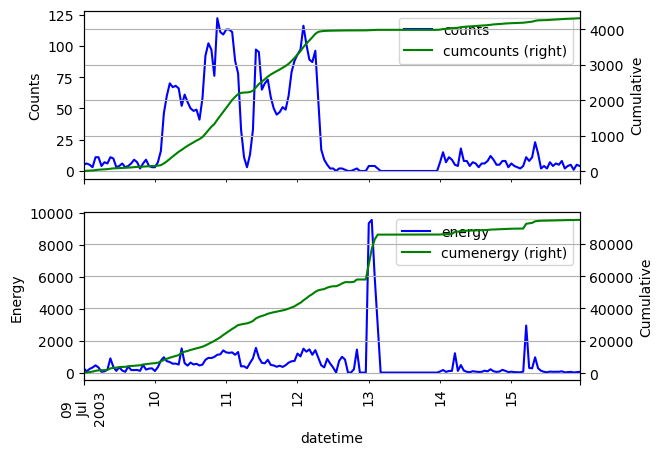

,magnitude,energy,latitude,longitude,depth,filename,duration,classification,counts,cumcounts,cumenergy
datetime,,,,,,,,,,,
2003-07-09 00:00:00,4.793946,282.364539,0,0,0,20030709T00001520030709T00105220030709T0017472...,192.140000,0,5,5,282.364539
2003-07-09 01:00:00,3.642724,71.066590,0,0,0,20030709T01001520030709T01193120030709T0121342...,164.106666,0,6,11,353.431129
2003-07-09 02:00:00,4.561242,229.195434,0,0,0,20030709T02225020030709T02300120030709T0230392...,58.743335,0,5,16,582.626563
2003-07-09 03:00:00,3.922704,318.453587,0,0,0,20030709T03054720030709T03531820030709T035334,45.769999,0,3,19,901.080149
2003-07-09 04:00:00,10.125266,453.194153,0,0,0,20030709T04001520030709T04032920030709T0404322...,272.840001,0,11,30,1354.274303
...,...,...,...,...,...,...,...,...,...,...,...
2003-07-15 19:00:00,2.283157,29.974560,0,0,0,20030715T19242520030715T19255020030715T1930272...,46.760001,0,4,4299,94750.657979
2003-07-15 20:00:00,2.989224,44.132509,0,0,0,20030715T20105920030715T20390220030715T2045212...,41.896667,0,5,4304,94794.790488
2003-07-15 21:00:00,0.540419,6.465885,0,0,0,20030715T214103,8.183333,0,1,4305,94801.256373


In [21]:
import pandas as pd
catalog_all.plot_eventrate(binsize=pd.Timedelta(hours=1))

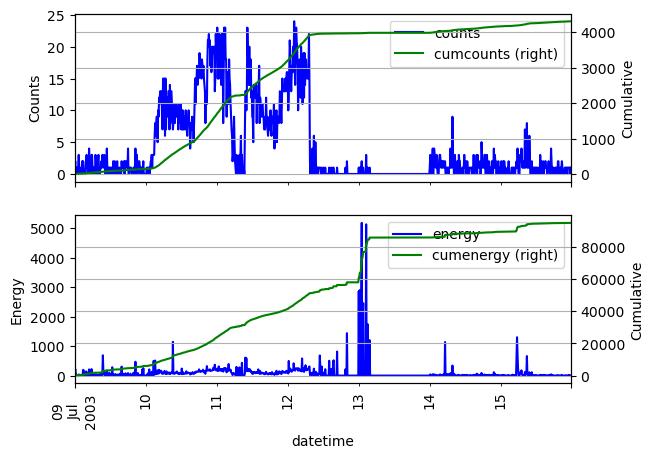

,magnitude,energy,latitude,longitude,depth,filename,duration,classification,counts,cumcounts,cumenergy
datetime,,,,,,,,,,,
2003-07-09 00:00:00,0.441214,4.590089,0,0,0,20030709T000015,120.000000,0,1,1,4.590089
2003-07-09 00:10:00,2.458253,223.791428,0,0,0,20030709T00105220030709T001747,34.973333,0,2,3,228.381518
2003-07-09 00:20:00,0.000000,0.000000,0,0,0,0,0.000000,0,0,3,228.381518
2003-07-09 00:30:00,1.010757,32.819771,0,0,0,20030709T003813,20.686667,0,1,4,261.201289
2003-07-09 00:40:00,0.883722,21.163250,0,0,0,20030709T004000,16.480000,0,1,5,282.364539
...,...,...,...,...,...,...,...,...,...,...,...
2003-07-15 23:00:00,0.932011,25.004417,0,0,0,20030715T230658,10.780000,0,1,4311,94854.435789
2003-07-15 23:10:00,0.559924,6.916487,0,0,0,20030715T231936,9.716667,0,1,4312,94861.352275
2003-07-15 23:20:00,0.700489,11.239168,0,0,0,20030715T232225,17.333334,0,1,4313,94872.591443


In [22]:
catalog_all.plot_eventrate(binsize=pd.Timedelta(minutes=10))

The 10-minute binsize plot gives us a better indication of the rapid drop in detected event counts. We can zoom in on this with:

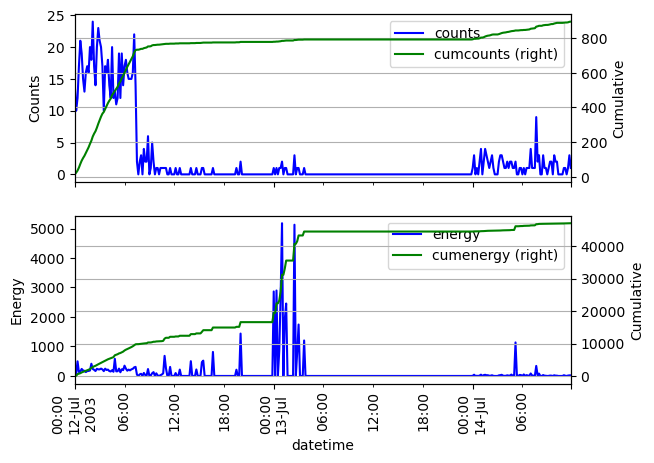

In [25]:
import datetime
time_limits = [datetime.datetime(2003, 7, 12, 0, 0, 0), datetime.datetime(2003, 7, 14, 12, 0, 0)]
axs = catalog_all.plot_eventrate(binsize=pd.Timedelta(minutes=10), time_limits=time_limits)

How would you interpret the drop in event rate if you didn't have the magnitude or energy release rate plot too? Probably as a drop in overall seismicity!

### Observations:
- Most of the detected events occur in a 56-hour period from 2003/07/10 00:00, peaking around 120 events per hour.
- There is an abrupt drop in triggered event rate beginning at 2003/07/12 08:00
- The magnitude of events rises sharply from about 2003/07/12 12:00 through to 2003/07/13 02:00. Only the largest events trigger because of the high background "tremor" from lahars and pyroclastic flows.
- The energy release rate (from cumulative magnitude) peaks around the start of 2003/07/13 for about 4 hours.

### Key points:
- <b>Catalogs are flawed. They often show no seismicity when seismicity and hazards are peaking!</b>
- <b>Event rate and Energy release rates give us different information!</b>

